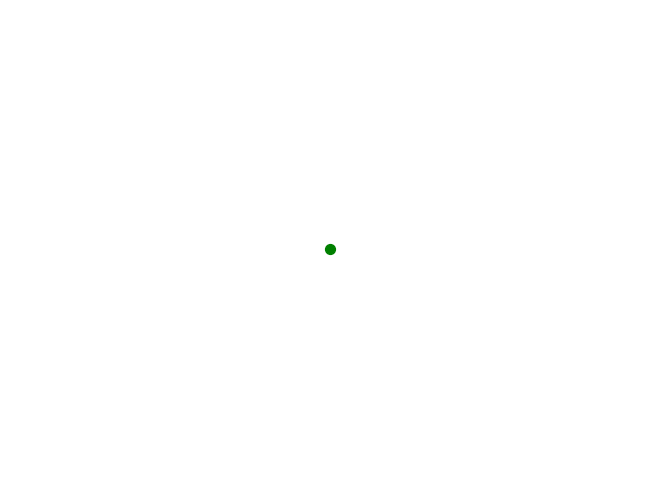

In [2]:
####################################################################################################################
####################################################################################################################
#PRE-PROCESSING
####################################################################################################################
####################################################################################################################



#Import pacakges
from datetime import datetime
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import gc
import highspy
from pyomo.common.timing import TicTocTimer
import os

if str(os.getcwd()) != "C:\\Users\\MLJ\\Downloads\\ECM Simple\\scripts":
    os.chdir(".\\scripts")


import sympy as sp
import statsmodels.api as sm

#import scripts
import preprocessor_simple as prep
import regions_integrated2
#import postprocessor as post

####################################################################################################################


In [3]:

import numpy as np
import re
from itertools import product
import os

def ECMModel_price(all_frames, setA, H2Price, H2PriceSet, sense=pyo.minimize, as_block=False):
    """ Create a block structure for restore model

    Args:
        global_region (range) : range of regions from (1,26)
        global_month (integer) : number of months to solve model for from (1,12)
        global_hour (integer): #number of hours to solve month for from (1,577)
        ***** All other parameters, variables, and dataframes are created within this function

    Returns:
        model (Pyomo ConcreteModel) : the instantiated model
    """
    
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    
    ## ADD TO CREATE BLOCKS

    if as_block:
        self = pyo.Block() 
    else:
        self = pyo.ConcreteModel(name='ElectricityModel')

    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################

    #self.dual = Suffix(direction=Suffix.IMPORT)

        

        ####################################################################################################################
        #Switches
        # TODO: figure out why certain year/region combos are unbounded
        # TODO: add test_region and years to scedes file
        
    self.sw_trade =     setA.sw_trade
    self.sw_expansion = setA.sw_expansion
    self.sw_agg_years = setA.sw_agg_years
    self.sw_rm =        setA.sw_rm
    self.sw_ramp =      setA.sw_ramp
    self.sw_reserves =  setA.sw_reserves
    self.sw_learning =  setA.sw_learning
    self.sw_h2int = 0
        
        ####################################################################################################################
        #Sets

    self.hr = pyo.Set(initialize = setA.hr) #change hours (1-48) or (1-577)?
    self.day = pyo.Set(initialize = setA.day)
    self.y = pyo.Set(initialize = setA.y)
    self.s = pyo.Set(initialize = setA.s)

    self.r = pyo.Set(initialize = range(1,26))
    self.r_can = pyo.Set(initialize = range(29,34))

    self.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
    self.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

    #Create sparse sets 
    def create_subsets(df,col,subset):
        df = df[df[col].isin(subset)].dropna()
        return df

    def create_hourly_sets(df):
        df = pd.merge(df,
                    all_frames['Map_hr_s'].reset_index(),
                    on=['s'], how='left').drop(columns=['s'])
        return df

    index_list = ['pt','y','r','steps','hr'] 

    self.GenSet = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptg))
        .set_index(index_list).index
        )
    
    self.ptd_upper_set = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptd))
        .set_index(index_list).index
        )
    
    self.pth_upper_set = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pth),
                'steps',[2]))
        .set_index(index_list).index
        )
    
    self.Gen_ramp_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptc)),
                'hr',setA.hr23)
        .set_index(index_list).index
        )
    
    self.FirstHour_gen_ramp_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptc)),
                'hr',setA.hr1)
        .set_index(index_list).index
        )
    
    self.HydroSet = pyo.Set(initialize = all_frames['HydroCapFactor'].index)
    self.IdaytqSet = pyo.Set(initialize = all_frames['Idaytq'].index)
    self.LoadSet = pyo.Set(initialize = all_frames['Load'].index)

    self.StorageSet = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pts))
        .set_index(index_list).index
        )
            
    self.H2GenSet = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pth2))
        .set_index(index_list).index
        )
    
    self.UnmetSet = self.r * self.y * self.hr
    self.HydroMonthsSet = pyo.Set(
        initialize = create_subsets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pth),'steps',[1]
            ).drop(columns=['steps']).set_index(['pt','y','r','s']).index
        )
    
    #TODO: move ptd to pt set list

    self.StorageBalance_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pts)),
                'hr',setA.hr23)
        .set_index(index_list).index
        )

    self.FirstHourStorageBalance_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pts)),
                'hr',setA.hr1)
        .set_index(index_list).index
        )

    self.ptiUpperSet = pyo.Set(initialize = all_frames['ptiUpperSet'].index)        
    #self.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)

    def capacitycredit_df():
        df = create_hourly_sets(all_frames['SupplyCurve'].reset_index())
        df = pd.merge(df,all_frames['ptiUpperSet'].reset_index(),how='left',on=index_list
                        ).rename(columns={'SolWindCapFactor':'CapacityCredit'})
        df['CapacityCredit'] = df['CapacityCredit'].fillna(1)
        df2 = pd.merge(all_frames['HydroCapFactor'].reset_index(),all_frames['Map_hr_d'].reset_index(),
                    on=['day'], how='left').drop(columns=['day'])
        df2['pt'] = setA.pth[0]
        df = pd.merge(df,df2,how='left',on=['pt','r','hr'])
        df.loc[df['pt'].isin(setA.pth),'CapacityCredit'] = df['HydroCapFactor']
        df = df.drop(columns=['SupplyCurve','HydroCapFactor']).set_index(index_list)
        return df

    if self.sw_expansion:
        if self.sw_learning > 0:
            self.LearningRateSet = pyo.Set(initialize = all_frames['LearningRate'].index)
            self.CapCost0Set = pyo.Set(initialize = all_frames['CapCost_y0'].index)
            self.LearningPtSet = pyo.Set(initialize = all_frames['SupplyCurve_learning'].index)
        self.CapCostSet = pyo.Set(initialize = all_frames['CapCost'].index)
        self.FOMCostSet = pyo.Set(initialize=all_frames['FOMCost'].index)
        self.allowBuildsSet = pyo.Set(initialize=all_frames['allowBuilds'].index)
        self.RetSet = pyo.Set(initialize=all_frames['RetSet'].index)
        self.CapacityCreditSet = pyo.Set(initialize=capacitycredit_df().index)

    if self.sw_trade:
        self.TranCostSet = pyo.Set(initialize = all_frames['TranCost'].index)
        self.TranLimitSet = pyo.Set(initialize = all_frames['TranLimit'].index)
        self.TradeSet = pyo.Set(
            initialize = create_hourly_sets(
                all_frames['TranLimit'].reset_index()
                ).set_index(['r', 'r1', 'y', 'hr']).index
            )
        
        self.TranCostCanSet = pyo.Set(initialize=all_frames['TranCostCan'].index)
        self.TranLimitCanSet = pyo.Set(initialize = all_frames['TranLimitCan'].index)
        self.TranLineLimitCanSet = pyo.Set(initialize = all_frames['TranLineLimitCan'].index)
        self.TradeCanSet = pyo.Set(
            initialize = pd.merge(
                all_frames['TranLimitCan'].reset_index(), all_frames['TranLineLimitCan'].reset_index(), how="inner"
                ).drop(columns=['TranLimitCan']).set_index(['r', 'r1', 'y','CSteps', 'hr']).index
            )

    if self.sw_ramp:
        self.RampUp_CostSet = pyo.Set(initialize=all_frames['RampUp_Cost'].index)
        self.RampRateSet = pyo.Set(initialize=all_frames['RampRate'].index)

        self.RampSet = pyo.Set(
            initialize = create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptc))
            .set_index(index_list).index
            )        

    if self.sw_reserves:
        self.ProcurementSet = pyo.Set(initialize=
            pd.merge(create_hourly_sets(all_frames['SupplyCurve'].reset_index()),
                        pd.DataFrame({'restypes': setA.restypes}),
                        how='cross').set_index(['restypes']+index_list).index
        )
        
        self.RegReservesCostSet = pyo.Set(initialize=all_frames['RegReservesCost'].index)
        self.ResTechUpperBoundSet = pyo.Set(initialize=all_frames['ResTechUpperBound'].index)

    ####################################################################################################################
    #Parameters

    self.Storagelvl_cost = pyo.Param(initialize=0.00000001)
    self.UnmetLoad_penalty = pyo.Param(initialize=500)
    self.Idaytq = pyo.Param(self.IdaytqSet, initialize = all_frames['Idaytq'], default = 0)
    self.Load = pyo.Param(self.LoadSet, initialize = all_frames['Load'], default = 0)
    self.HydroCapFactor = pyo.Param(self.HydroSet, initialize = all_frames['HydroCapFactor'], default = 0)
    
    self.BatteryChargeCap = pyo.Param(
        self.StorageSet, 
        initialize = create_hourly_sets(
            create_subsets(
                all_frames['SupplyCurve'].reset_index(),'pt',setA.pts
                )
            ).set_index(index_list), 
        default = 0
        )
    
    self.BatteryEfficiency = pyo.Param(setA.pts, initialize = all_frames['BatteryEfficiency'], default = 0)
    self.HourstoBuy= pyo.Param(setA.pts, initialize = all_frames['HourstoBuy'], default = 0)
    self.Dayweights = pyo.Param(self.hr, initialize = all_frames['Dayweights'], default = 0)
    self.SupplyPrice = pyo.Param(self.SupplyPriceSet, initialize = all_frames['SupplyPrice'], default = 0)
    self.SupplyCurve = pyo.Param(self.SupplyCurveSet, initialize = all_frames['SupplyCurve'], default = 0)
    self.SolWindCapFactor = pyo.Param(self.ptiUpperSet, initialize=all_frames['ptiUpperSet'], default = 0) 
    
    #comment out mutable for h2 price
    #self.H2Price = pyo.Param(self.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
    #self.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
    
    self.year_weights = pyo.Param(self.y, initialize = all_frames['year_weights'], default = 0)
    self.Map_hr_s = pyo.Param(self.hr, initialize = all_frames['Map_hr_s'], default = 0) #all_frames['Map_hr_s'].loc[hr]['s']
    self.Hr_weights = pyo.Param(self.hr, initialize=all_frames['Hr_weights']['Hr_weights'], default=0) #all_frames['Hr_weights']['Hr_weights'][hr]
    self.Map_hr_d = pyo.Param(self.hr, initialize = all_frames['Map_hr_d']['day'], default=0)

    if self.sw_expansion:
        # if learning is not to be solved nonlinearly directly in the obj
        if self.sw_learning < 2:
            if self.sw_learning == 0:
                mute = False
            else:
                mute = True
            self.capacity_costs_learning = pyo.Param(self.CapCostSet, initialize = all_frames['CapCost'], default = 0, mutable=mute)
        # if learning is non-linear
        if self.sw_learning > 0:
            self.LearningRate = pyo.Param(self.LearningRateSet, initialize = all_frames['LearningRate'], default = 0)
            self.CapCost_y0 = pyo.Param(self.CapCost0Set, initialize = all_frames['CapCost_y0'], default = 0)
            self.SupplyCurve_learning = pyo.Param(self.LearningPtSet, initialize = all_frames['SupplyCurve_learning'], default = 0)
        
        self.FOMCost = pyo.Param(self.FOMCostSet, initialize=all_frames['FOMCost'], default=0)
        self.CapacityCredit = pyo.Param(self.CapacityCreditSet, initialize=capacitycredit_df(), default=0)

    if self.sw_trade:
        self.TranCost = pyo.Param(self.TranCostSet, initialize = all_frames['TranCost'], default = 0)
        self.TranLimit = pyo.Param(self.TranLimitSet, initialize = all_frames['TranLimit'], default = 0)

        self.TranCostCan = pyo.Param(self.TranCostCanSet, initialize=all_frames['TranCostCan'], default=0)
        self.TranLimitCan = pyo.Param(self.TranLimitCanSet, initialize=all_frames['TranLimitCan'], default=0)
        self.TranLineLimitCan = pyo.Param(self.TranLineLimitCanSet, initialize = all_frames['TranLineLimitCan'], default = 0)
    
    if self.sw_rm:
        self.ReserveMargin = pyo.Param(self.r, initialize=all_frames['ReserveMargin'], default=0)
        
    if self.sw_ramp:
        self.RampUp_Cost = pyo.Param(self.RampUp_CostSet, initialize=all_frames['RampUp_Cost'], default=0)
        self.RampDown_Cost = pyo.Param(self.RampUp_CostSet, initialize=all_frames['RampDown_Cost'], default=0)
        self.RampRate = pyo.Param(self.RampRateSet, initialize=all_frames['RampRate'], default=0)

    if self.sw_reserves:
        self.RegReservesCost = pyo.Param(self.RegReservesCostSet, initialize=all_frames['RegReservesCost'], default=0)
        self.ResTechUpperBound = pyo.Param(self.ResTechUpperBoundSet, initialize=all_frames['ResTechUpperBound'], default=0)
    
    

    ####################################################################################################################
    #Upper Bounds

    if self.sw_trade:
        def Trade_upper(self, r, r1, y, hr):
            return (0, self.TranLimit[(r, r1,
                                        self.Map_hr_s[hr], y)] * self.Hr_weights[hr])

    ####################################################################################################################
    #Variables

    self.Storage_inflow = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #Storage inflow in hour h #GW
    self.Storage_outflow = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #Storage outflow in hour h #GW
    self.Storage_level = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #storage energy level in hour h #GWh
    self.Generation = pyo.Var(self.GenSet, within=pyo.NonNegativeReals) #Operated capacity GW use of technology group T in hour h #GW
    self.unmet_Load = pyo.Var(self.UnmetSet, within=pyo.NonNegativeReals) #slack variable #GW

    self.TotalCapacity = pyo.Var(self.SupplyCurveSet, within=pyo.NonNegativeReals) #Total capacity (existing + new - retirements) #GW

    if self.sw_expansion:
        self.CapacityBuilds = pyo.Var(self.CapCostSet, within=pyo.NonNegativeReals) #GW
        self.CapacityRetirements = pyo.Var(self.RetSet, within=pyo.NonNegativeReals) #GW

    if self.sw_trade:
        self.TradeToFrom = pyo.Var(self.TradeSet, within=pyo.NonNegativeReals, bounds = Trade_upper) # Trade to region r from r1 #GW
        self.TradeToFromCan = pyo.Var(self.TradeCanSet, within=pyo.NonNegativeReals) # Trade to region r from r1 with canada #GW

    if self.sw_rm:
        self.AvailStorCap = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #Available storage capacity #GW
        
    if self.sw_ramp:
        self.RampUp = pyo.Var(self.RampSet, within=pyo.NonNegativeReals)
        self.RampDown = pyo.Var(self.RampSet, within=pyo.NonNegativeReals)

    if self.sw_reserves:
        self.ReservesProcurement = pyo.Var(self.ProcurementSet, within=pyo.NonNegativeReals)
        

    ####################################################################################################################
    #Objective Function
    self.StorageSetByHour = pyo.Set(self.hr)
    self.GenSetByHour = pyo.Set(self.hr)
    #self.H2GenSetByHour = {}

    def populate_by_hour_sets_rule(m):
        for (tech, y, reg, step, hour) in m.StorageSet:
            m.StorageSetByHour[hour].add((tech, y, reg, step))
        for (tech, y, reg, step, hour) in m.GenSet:
            m.GenSetByHour[hour].add((tech, y, reg, step))
        #for (tech, y, reg, step, hour) in m.H2GenSet:
        #    if (hour) not in m.H2GenSetByHour:
        #        m.H2GenSetByHour[hour] = []  # TBD- collapse with default key value
        #    m.H2GenSetByHour[hour].append((tech, y, reg, step))
                
    self.populate_by_hour_sets = pyo.BuildAction(rule=populate_by_hour_sets_rule)

    #Variable Objectivefunction
    #make sure to correct all costs to multiply by year weights
    def dispatchCost(self):
        return sum(self.Dayweights[hr] * (
                    sum(self.year_weights[y] * (0.5 * self.SupplyPrice[(reg,s,tech,step,y)] \
                        * (self.Storage_inflow[(tech,y,reg,step,hr)] + self.Storage_outflow[(tech,y,reg,step,hr)]) \
                        + (self.Hr_weights[hr] * self.Storagelvl_cost) \
                        * self.Storage_level[(tech,y,reg,step,hr)]) \
                        for (tech, y, reg, step) in self.StorageSetByHour[hr]) \
                    + sum(self.year_weights[y] * self.SupplyPrice[(reg,s,tech,step,y)]
                                                    * self.Generation[(tech, y, reg, step, hr)] \
                            for (tech, y, reg, step) in self.GenSetByHour[hr]) \
            ) for hr in self.hr if (s := self.Map_hr_s[hr])) \
                + sum(self.Dayweights[hr] * 
                        self.year_weights[y] * H2Price[reg,s,tech,step,y] * setA.H2_heatrate \
                        * self.Generation[(tech, y, reg, 1, hr)] \
                    for (tech, y, reg, step, hr) in self.H2GenSet if (s := self.Map_hr_s[hr]))
    self.dispatchCost = pyo.Expression(expr=dispatchCost)

    def unmetLoadCost(self):
        return sum(self.Dayweights[hour] *
                    self.year_weights[y] * self.unmet_Load[(reg, y, hour)] * self.UnmetLoad_penalty \
                        for (reg, y, hour) in self.UnmetSet)
    self.unmetLoadCost = pyo.Expression(expr=unmetLoadCost)

    if self.sw_trade:
        def tradeCost(self):
            return sum(self.Dayweights[hour] * self.year_weights[y] * self.TradeToFrom[(reg,reg1,y,hour)] * self.TranCost[(reg,reg1,y)] \
                                for (reg,reg1,y,hour) in self.TradeSet) \
                        + sum(self.Dayweights[hour] * self.year_weights[y] * self.TradeToFromCan[(reg, reg_can, y, CSteps, hour)] * self.TranCostCan[(reg, reg_can, CSteps, y)] \
                                for(reg, reg_can, y, CSteps, hour) in self.TradeCanSet)
        self.tradeCost = pyo.Expression(expr=tradeCost)


    if self.sw_ramp: #ramping
        def RampCost(self):
            return sum(self.Dayweights[hour] * self.year_weights[y] * (self.RampUp[(ptc, y, reg, step, hour)] * self.RampUp_Cost[ptc]
                        + self.RampDown[(ptc, y, reg, step, hour)] * self.RampDown_Cost[ptc]) \
                        for (ptc, y, reg, step, hour) in self.RampSet)
        self.RampCost = pyo.Expression(expr=RampCost)

    if self.sw_expansion:
        
        # nonlinear expansion costs
        if self.sw_learning == 2:
            
            def capExpansionCost(self): #TODO: not sure if I need self.year_weights[y] weighting here, I don't think so but maybe?
                return sum((self.CapCost_y0[(reg, pt, step)] \
            * (((self.SupplyCurve_learning[pt]  \
                + 0.0001*(y - setA.start_year)
                + sum(sum(self.CapacityBuilds[(r, pt, year, steps)] for year in setA.y if year < y) 
                    for (r, tech, steps) in self.CapCost0Set if tech == pt)) \
                / self.SupplyCurve_learning[pt]) \
            ** (-1.0*self.LearningRate[pt])) )
                * self.CapacityBuilds[(reg,pt,y,step)] \
                            for (reg,pt,y,step) in self.CapCostSet)
            self.capExpansionCost = pyo.Expression(expr=capExpansionCost)
        else: #linear expansion costs
        
            def capExpansionCost(self): #TODO: not sure if I need self.year_weights[y] weighting here, I don't think so but maybe?
                return sum(self.capacity_costs_learning[(reg,pt,y,step)] * self.CapacityBuilds[(reg,pt,y,step)] \
                            for (reg,pt,y,step) in self.CapCostSet)
            self.capExpansionCost = pyo.Expression(expr=capExpansionCost)

        # choosing summer for capacity, may want to revisit this assumption
        def FOMCostObj(self):
            return sum(self.year_weights[y] * self.FOMCost[(reg, pt, steps)] \
                        * self.TotalCapacity[(reg, s, pt, steps, y)]  \
                                for (reg,s,pt,steps,y) in self.SupplyCurveSet if s==2) #need to fix this weighting

        self.FOMCostObj = pyo.Expression(expr=FOMCostObj)

    if self.sw_reserves: # operating reserves
        def opresCost(self):
            return sum( (self.RegReservesCost[pt] if restype == 2 else 0.01)
                        * self.Dayweights[hr] * self.year_weights[y] \
                        * self.ReservesProcurement[(restype, pt, y, r, steps, hr)] \
                                for (restype, pt, y, r, steps, hr) in self.ProcurementSet)
        self.opresCost = pyo.Expression(expr=opresCost)

    def objFunction(self):
        return (self.dispatchCost + self.unmetLoadCost
                + (self.RampCost if self.sw_ramp else 0)
                + (self.tradeCost if self.sw_trade else 0)
                + (self.capExpansionCost + self.FOMCostObj if self.sw_expansion else 0)
                + (self.opresCost if self.sw_reserves else 0)
                )
            
    self.totalCost = pyo.Objective(rule=objFunction, sense = pyo.minimize)

    ####################################################################################################################
    #Constraints

    self.GenSetDemandBalance = {}
    self.StorageSetDemandBalance = {}
    self.TradeSetDemandBalance = {}
    self.TradeCanSetDemandBalance = {}
    def populate_demand_balance_sets_rule(m):
        for (tech, year, reg, step, hour) in m.GenSet:
            if (year, reg, hour) not in m.GenSetDemandBalance:
                m.GenSetDemandBalance[(year, reg, hour)] = []  # TBD- collapse with default key value
            m.GenSetDemandBalance[(year, reg, hour)].append((tech, step))
        for (tech, year, reg, step, hour) in m.BatteryChargeCap:
            if (year, reg, hour) not in m.StorageSetDemandBalance:
                m.StorageSetDemandBalance[(year, reg, hour)] = []
            m.StorageSetDemandBalance[(year, reg, hour)].append((tech, step))
        if m.sw_trade == 1:
            for (reg, reg1, year, hour) in m.TradeSet:
                if (year, reg, hour) not in m.TradeSetDemandBalance:
                    m.TradeSetDemandBalance[(year, reg, hour)] = []
                m.TradeSetDemandBalance[(year, reg, hour)].append(reg1)
            for (reg, reg1, year, CSteps, hour) in m.TradeCanSet:
                if (year, reg, hour) not in m.TradeCanSetDemandBalance:
                    m.TradeCanSetDemandBalance[(year, reg, hour)] = []
                m.TradeCanSetDemandBalance[(year, reg, hour)].append((reg1, CSteps))
    self.populate_demand_balance_sets = pyo.BuildAction(rule=populate_demand_balance_sets_rule)

    #Property: ShadowPrice
    @self.Constraint(self.LoadSet)
    def Demand_balance(self, r, y, hr):
        return self.Load[(r, y, hr)] <= \
                sum(self.Generation[(tech, y, r, step, hr)] for (tech, step) in self.GenSetDemandBalance[(y, r, hr)]) \
                + sum(self.Storage_outflow[(tech,y,r,step,hr)] - self.Storage_inflow[(tech,y,r,step,hr)] \
                    for (tech, step) in self.StorageSetDemandBalance[(y,r,hr)]) \
                + self.unmet_Load[(r, y, hr)] \
                + (sum(self.TradeToFrom[(r,reg1,y,hr)]*(1-setA.TransLoss) - self.TradeToFrom[(reg1,r,y,hr)] \
                    for (reg1) in self.TradeSetDemandBalance[(y, r, hr)]) if self.sw_trade else 0) \
                + (sum(self.TradeToFromCan[(r, r_can, y, CSteps, hr)] * (1 - setA.TransLoss) \
                    for (r_can, CSteps) in self.TradeCanSetDemandBalance[(y, r, hr)]) if (self.sw_trade == 1 and r in setA.r_can_conn) else 0)

    # #First hour
    @self.Constraint(self.FirstHourStorageBalance_set)
    def FirstHourStorageBalance(self, pts, y, r, steps, hr1):
        return self.Storage_level[(pts,y,r,steps,hr1)] == self.Storage_level[(pts,y,r,steps,hr1 + setA.num_hr_day-1)] \
            + self.BatteryEfficiency[pts] * self.Storage_inflow[(pts,y,r,steps,hr1)] - self.Storage_outflow[(pts,y,r,steps,hr1)]

    # #Not first hour
    @self.Constraint(self.StorageBalance_set)
    def StorageBalance(self, pts, y, r, steps, hr23):
        return self.Storage_level[(pts,y,r,steps,hr23)] == self.Storage_level[(pts,y,r,steps,hr23-1)] \
            + self.BatteryEfficiency[pts] * self.Storage_inflow[(pts,y,r,steps,hr23)] - self.Storage_outflow[(pts,y,r,steps,hr23)]

    self.DaySHydro = pyo.Set(self.s)
    self.HourSHydro = pyo.Set(self.s)

    def populate_hydro_sets_rule(m):
        for (s, hr) in all_frames['Map_hr_s'].reset_index().set_index(['s', 'hr']).index:
            m.HourSHydro[s].add(hr)
        for (s, day) in all_frames['Map_day_s'].reset_index().set_index(['s', 'day']).index:
            m.DaySHydro[s].add(day)

    self.populate_hydro_sets = pyo.BuildAction(rule=populate_hydro_sets_rule)

    @self.Constraint(self.HydroMonthsSet)
    def Hydro_Gen_Cap(self, pth, y, r, s):
        return sum(self.Generation[pth, y, r, 1, hr] * \
                self.Idaytq[self.Map_hr_d[hr]] \
                    for hr in self.HourSHydro[s]) \
            <= sum(self.TotalCapacity[(r, s, pth, 1, y)] \
                * self.HydroCapFactor[r, day] \
                * self.Idaytq[day] \
                for day in self.DaySHydro[s]) * 24 # leave as 24


    ####################################################################################################################
    #Constraints Generation Variable Upper Bounds

    @self.Constraint(self.ptd_upper_set)
    def ptd_upper(self, ptd, y, r, steps, hr):
        return (self.Generation[(ptd,y,r,steps,hr)]
                + (sum(self.ReservesProcurement[(restype, ptd, y, r, steps, hr)]
                        for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], ptd, steps, y)] \
                * self.Hr_weights[hr])

    @self.Constraint(self.pth_upper_set)
    def pth_upper(self, pth, y, r, steps, hr):
        return ((self.Generation[(pth,y,r,steps,hr)] \
                    + sum(self.ReservesProcurement[(restype, pth, y, r, steps, hr)]
                            for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pth, steps, y)] \
                * self.HydroCapFactor[(r, self.Map_hr_d[hr])] \
                * self.Hr_weights[hr])

    @self.Constraint(self.ptiUpperSet)
    def pti_upper(self, pti, y, r, steps, hr):
        return (self.Generation[(pti,y,r,steps,hr)] \
                + (sum(self.ReservesProcurement[(restype, pti, y, r, steps, hr)]
                        for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pti, steps, y)] \
                * self.SolWindCapFactor[(pti,y,r,steps,hr)] \
                * self.Hr_weights[hr])

    @self.Constraint(self.StorageSet)
    def Storage_inflow_upper(self, pt, y, r, steps, hr):
        return (self.Storage_inflow[(pt,y,r,steps,hr)] \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)] \
                    * self.Hr_weights[hr])

    # TODO check if it's only able to build in regions with existing capacity?
    @self.Constraint(self.StorageSet)
    def Storage_outflow_upper(self, pt, y, r, steps, hr):
        return (self.Storage_outflow[(pt,y,r,steps,hr)] \
                + (sum(self.ReservesProcurement[(restype, pt, y, r, steps, hr)] \
                        for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)] \
                    * self.Hr_weights[hr])

    @self.Constraint(self.StorageSet)
    def Storage_level_upper(self, pt, y, r, steps, hr):
        return  self.Storage_level[(pt,y,r,steps,hr)] <= \
                    self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)] \
                    * self.HourstoBuy[(pt)]

    @self.Constraint(self.SupplyCurveSet)
    def totalCapacityEq(self, r, s, pt, steps, y):
            return self.TotalCapacity[(r, s, pt, steps, y)] == \
                self.SupplyCurve[(r, s, pt, steps, y)] \
                    + (sum(self.CapacityBuilds[(r, pt, year, steps)] for year in setA.y if year <= y) \
                        if self.sw_expansion and (pt, steps) in self.allowBuildsSet else 0) \
                    - (sum(self.CapacityRetirements[(pt, year, r, steps)] for year in setA.y if year <= y) \
                        if self.sw_expansion and (pt, y, r, steps) in self.RetSet else 0)

    if self.sw_expansion:
        @self.Constraint(self.RetSet)
        def Ret_upper(self, pt, y, r, steps):
            return self.CapacityRetirements[(pt, y, r, steps)] <= \
                ((self.SupplyCurve[(r, 2, pt, steps, y)] if (r, 2, pt, steps, y) in self.SupplyCurveSet else 0) \
                    + (sum(self.CapacityBuilds[(r, pt, year, steps)] for year in setA.y if year < y) \
                        if (pt, steps) in self.allowBuildsSet else 0) \
                    - sum(self.CapacityRetirements[(pt, year, r, steps)] for year in setA.y if year < y) \
                    )
                    

    ### trade upper bound

    if self.sw_trade and all_frames['TranLineLimitCan'].size != 0:
        # run time seems worth it to create trade sets rule if there are , adds 9 sec (29 to 23 sec) build time if trade on with all regions

        # this may have made it run slightly slower with only 3 regions
        self.TradeCanSetUpper = {}
        self.TradeCanLineSetUpper = {}
        def populate_trade_sets_rule(m):
            for (reg, reg1, year, CSteps, hour) in m.TradeCanSet:
                if (reg, reg1, year, hour) not in m.TradeCanLineSetUpper:
                    m.TradeCanLineSetUpper[(reg, reg1, year, hour)] = []
                m.TradeCanLineSetUpper[(reg, reg1, year, hour)].append((CSteps))
                if (reg1, year, CSteps, hour) not in m.TradeCanSetUpper:
                    m.TradeCanSetUpper[(reg1, year, CSteps, hour)] = []
                m.TradeCanSetUpper[(reg1, year, CSteps, hour)].append((reg))

        self.populate_trade_sets = pyo.BuildAction(rule=populate_trade_sets_rule)

        @self.Constraint(self.TranLineLimitCanSet)
        def tradelinecan_upper(self, r, r_can, y, hr):
            return (sum(self.TradeToFromCan[(r, r_can, y, c, hr)] for c in self.TradeCanLineSetUpper[(r, r_can, y, hr)]) \
                    <= \
                self.TranLineLimitCan[(r, r_can, y, hr)] * self.Hr_weights[hr])

        @self.Constraint(self.TranLimitCanSet)
        def tradecan_upper(self, r_can, CSteps, y, hr):
            return (sum(self.TradeToFromCan[(r,r_can,y,CSteps,hr)] for r in self.TradeCanSetUpper[(r_can, y, CSteps, hr)]) \
                    <= \
                self.TranLimitCan[(r_can, CSteps,y, hr)] * self.Hr_weights[hr])

    if self.sw_expansion and self.sw_rm:
        # must meet reserve margin requirement
        # apply to every hour, a fraction above the final year's load
        # ReserveMarginReq <= sum(Max capacity in that hour)

        self.SupplyCurveRM = {}

        def populate_RM_sets_rule(m):
            for (reg,s,tech,step,year) in m.SupplyCurveSet:
                if (year, reg, s) not in m.SupplyCurveRM:
                    m.SupplyCurveRM[(year, reg, s)] = []  # TBD- collapse with default key value
                m.SupplyCurveRM[(year, reg, s)].append((tech, step))

        self.populate_RM_sets = pyo.BuildAction(rule=populate_RM_sets_rule)

        @self.Constraint(self.LoadSet)
        def ReserveMarginLower(self, r, y, hr):
            return (self.Load[(r, y, hr)] * (1 + self.ReserveMargin[r]) \
                        <= \
                        self.Hr_weights[hr] \
                        * sum(
                            (self.CapacityCredit[(pt,y,r,steps,hr)] \
                            * (self.AvailStorCap[(pt, y, r, steps, hr)] if pt in setA.pts
                                else self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)]) ) \
                            for (pt, steps) in self.SupplyCurveRM[(y, r, self.Map_hr_s[hr])]))
        
        # ensure available capacity to meet RM for storage < power capacity
        @self.Constraint(self.StorageSet)
        def AvailCapStor1_Upper(self, pts, y, r, steps, hr):
            return self.AvailStorCap[(pts, y, r, steps, hr)] <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pts, steps, y)]
        
        # ensure available capacity to meet RM for storage < existing SOC
        @self.Constraint(self.StorageSet)
        def AvailCapStor2_Upper(self, pts, y, r, steps, hr):
            return self.AvailStorCap[(pts, y, r, steps, hr)] <= \
                self.Storage_level[(pts,y,r,steps,hr)]   

    if self.sw_ramp:
        #First hour
        @self.Constraint(self.FirstHour_gen_ramp_set)
        def FirstHour_gen_ramp(self, ptc, y, r, steps, hr1):
            return (self.Generation[(ptc,y,r,steps,hr1)] \
                == self.Generation[(ptc,y,r,steps,hr1 + setA.num_hr_day-1)]
                    + self.RampUp[(ptc,y,r,steps,hr1)]
                    - self.RampDown[(ptc,y,r,steps,hr1)])

        # NOT first hour
        @self.Constraint(self.Gen_ramp_set)
        def Gen_ramp(self, ptc, y, r, steps, hr23):
            return (self.Generation[(ptc, y, r, steps, hr23)] \
                == self.Generation[(ptc, y, r, steps, hr23 - 1)]
                    + self.RampUp[(ptc, y, r, steps, hr23)] - \
                    self.RampDown[(ptc, y, r, steps, hr23)])

        @self.Constraint(self.RampSet)
        def RampUp_upper(self, ptc, y, r, steps, hr):
            return self.RampUp[(ptc, y, r, steps, hr)] <= \
                self.Hr_weights[hr] * self.RampRate[ptc] \
                * self.TotalCapacity[(r, self.Map_hr_s[hr], ptc, steps, y)]


        @self.Constraint(self.RampSet)
        def RampDown_upper(self, ptc, y, r, steps, hr):
            return self.RampDown[(ptc, y, r, steps, hr)] <= \
                self.Hr_weights[hr] * self.RampRate[ptc] \
                * self.TotalCapacity[(r, self.Map_hr_s[hr], ptc, steps, y)]

    if self.sw_reserves:

        self.ProcurementSetReserves = {}
        #wind set
        self.WindSetReserves = {}
        #solar set
        self.SolarSetReserves = {}
        def populate_reserves_sets_rule(m):
            for (restype, pt, year, reg, step, hour) in m.ProcurementSet:
                if (restype, reg, year, hour) not in m.ProcurementSetReserves:
                    m.ProcurementSetReserves[(restype, reg, year, hour)] = []
                m.ProcurementSetReserves[(restype, reg, year, hour)].append((pt, step))
            #
            for (pt, year, reg, step, hour) in m.ptiUpperSet:
                if (year, reg, hour) not in m.WindSetReserves:
                    m.WindSetReserves[(year, reg, hour)] = []
                if (year, reg, hour) not in m.SolarSetReserves:
                    m.SolarSetReserves[(year, reg, hour)] = []

                if pt in setA.ptw:
                    m.WindSetReserves[(year, reg, hour)].append((pt, step))
                elif pt in setA.ptsol:
                    m.SolarSetReserves[(year, reg, hour)].append((pt, step))

        self.populate_reserves_sets = pyo.BuildAction(rule=populate_reserves_sets_rule)

        # 3% of load
        @self.Constraint(self.LoadSet)
        def spinReservesRequirement(self, r, y, hr):
            return (sum(self.ReservesProcurement[(1, pt, y, r, step, hr)]
                        for (pt, step) in self.ProcurementSetReserves[(1, r, y, hr)])
                    >= 0.03 * self.Load[(r, y, hr)])

        # 1% of load + 0.5% of wind generation + 0.3% of solar capacity
        @self.Constraint(self.LoadSet)
        def regReservesRequirement(self, r, y, hr):
            return (sum(self.ReservesProcurement[(2, pt, y, r, step, hr)]
                        for (pt, step) in self.ProcurementSetReserves[(2, r, y, hr)]) \
                    >= 0.01 * self.Load[(r, y, hr)] \
                    + 0.005 * sum(self.Generation[(ptw,y,r,step,hr)] \
                                for (ptw, step) in self.WindSetReserves[(y, r, hr)]) \
                    + 0.003 * self.Hr_weights[hr]
                            * sum(self.TotalCapacity[(r, self.Map_hr_s[hr], ptsol, step, y)] \
                                for (ptsol, step) in self.SolarSetReserves[(y, r, hr)]))

        #  10% of wind generation + 4% of solar capacity
        @self.Constraint(self.LoadSet)
        def flexReservesRequirement(self, r, y, hr):
            return (sum(self.ReservesProcurement[(3, pt, y, r, step, hr)]
                        for (pt, step) in self.ProcurementSetReserves[(3, r, y, hr)])
                    >= \
                + 0.1 * sum(self.Generation[(ptw, y, r, step, hr)]
                            for (ptw, step) in self.WindSetReserves[(y, r, hr)]) \
                + 0.04 * self.Hr_weights[hr] \
                            * sum(self.TotalCapacity[(r, self.Map_hr_s[hr], ptsol, step, y)] \
                                    for (ptsol, step) in self.SolarSetReserves[(y, r, hr)]))

        @self.Constraint(self.ProcurementSet)
        def resProcurementUpper(self, restypes, pt, y, r, steps, hr):
            return self.ReservesProcurement[(restypes, pt, y, r, steps, hr)] <= \
                self.ResTechUpperBound[(restypes, pt)] * self.Hr_weights[hr] \
                * self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)]
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################

    ## ADD TO CREATE BLOCKS

    #deactivates objective function so we can create a new objective function with multiple blocks
    if as_block:
        self.totalCost.deactivate()
    
    return self

    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################



In [4]:
    

############################################
# RUN NEWW ECM MODEL BY ITSELF
############################################
model3 = pyo.ConcreteModel(name='MultiBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

test_years = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_reg.csv').dropna()['region'])

all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions),'C:/Users/MLJ/Downloads/ECM Simple/input/temp/')


model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = range(7,8))
model3.hr = pyo.Set(initialize = setin.hr)

# params to pass into ECM
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
#model3.GenSet = pyo.Set(initialize = all_frames['GenSet'].index)
model3.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)

model3.electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)

#params to pass into residential
model3.LoadSet = pyo.Set(initialize = all_frames['Load'].index)

model3.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

#Create sparse sets 
def create_subsets(df,col,subset):
    df = df[df[col].isin(subset)].dropna()
    return df

def create_hourly_sets(df):
    df = pd.merge(df,
                all_frames['Map_hr_s'].reset_index(),
                on=['s'], how='left').drop(columns=['s'])
    return df

index_list = ['pt','y','r','steps','hr'] 

model3.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )

############################################################################################################################################
### GENERATE ONLY RESTORE BLOCK TO INITIALIZE PARAMETER - GENERATION WHICH GETS PASSED INTO COAL MODEL
############################################################################################################################################
model3.first_block = ECMModel_price(all_frames, setin, model3.H2Price, model3.H2PriceSet, sense=pyo.minimize, as_block=True)


# STEP 1 - DEFINE NEW OBJECTIVE FUNCTION
print("creating new objective")
def total_profit_rule(model3):
    return model3.first_block.totalCost
model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)


print("solving model")
pyo.SolverFactory("appsi_highs").solve(model3)
print("model solved")

###############################################################################################
##############################################################################################

#PULL VARIABLES FROM CEM MODEL TO SEND INTO HYDROGEN MODULE
# PULL DUAL VALS TO SEND INTO ELEC PRICE FOR H2
# PULL H2 GENERATION FROM GENERATION VAR FOR H2 DEMAND

for c in model3.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="first_block.Demand_balance":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]


#####################

### ELEC PRICE MUST BE INDEXED BY REG AND YEAR ONLY
# ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model3.electricity_price[reg, yr].value = -model3.dual[model3.first_block.Demand_balance[reg, yr, 1]]
    #model3.electricity_price[reg, yr].value =  sum(-model3.dual[model3.first_block.Demand_balance[reg, yr, hr2]] for hr2 in model3.LoadSet[(hr2)])
    #model3.electricity_price[reg, yr].value = 
    #t = (sum( model3.dual[model3.first_block.Demand_balance[reg, yr, hr2]] \
                    #for (hr) in model3.LoadSet[(r, y, hr)]) ) 
    #model3.electricity_price[reg, yr].value =  sum(-model3.dual[model3.first_block.Demand_balance[reg, yr, hr2]] for hr2 in model3.hr)

# ASSIGN GENERATION TO H2_DEMAND
#r	s	pt	steps	y

for (tech, year, reg, step, hour) in model3.SupplyPriceSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    if tech==5:
        #model3.H2_Demand[reg, yr]() == model3.first_block.Generation[5, yr, r, steps, hr]()
        model3.H2_Demand[reg, yr]() == (sum(model3.first_block.Generation[5, yr, r, steps, hr]() \
                    for (steps, hr) in model3.SupplyPriceSet[(tech, yr, r, steps, hr)]) ) 

import pandas as pd
import random as rnd
import regions_integrated2
from pyomo.environ import *

creating new objective
solving model
model solved
Constraint first_block.Demand_balance


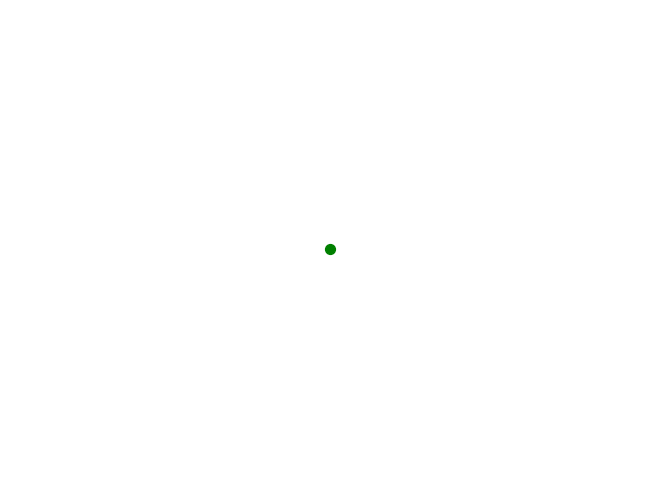

solving ecm alone first time
solved
Constraint Demand_balance
tolerance
1
Iteration
0
building h2 model
test
integrated
integrated
solving h2 model
h2 solved
Constraint first_block.demand_constraint
building and adding ecm
creating new objective
solving full model
Presolving model
332 rows, 372 cols, 1047 nonzeros
230 rows, 270 cols, 863 nonzeros
230 rows, 270 cols, 863 nonzeros
Presolve : Reductions: rows 230(-260); columns 270(-4998); elements 863(-450)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.0441608026e+02 Ph1: 113(88.9641); Du: 19(304.416) 0s
        178     7.8826689553e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 178
Objective value     :  7.8826689553e+05
HiGHS run time      :          0.00
solved
Constraint second_block.Demand_balance
checking tolerance
0.0
dummy elec
0
Coal supplied
0.37820640000000

In [65]:
##########################################################################################################################################################
##########################################################################################################################################################
# SINGLE OPTIMIZATION WITH ECM AND H2
##########################################################################################################################################################
##########################################################################################################################################################

import regions_integrated2

grid = regions_integrated2.Grid(regions_integrated2.Data())
grid.build_grid()

############################################
# RUN NEWW ECM MODEL BY ITSELF
############################################
model3 = pyo.ConcreteModel(name='MultiBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

test_years = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_reg.csv').dropna()['region'])

all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions),'C:/Users/MLJ/Downloads/ECM Simple/input/temp/')

# declare sets
model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = range(7,8))
model3.hr = pyo.Set(initialize = setin.hr)

# params to pass into ECM
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
#model3.GenSet = pyo.Set(initialize = all_frames['GenSet'].index)
model3.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)

model3.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.H2_DemandSet = pyo.Set(initialize=model3.regions*model3.year)
model3.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)

#params to pass into residential
model3.LoadSet = pyo.Set(initialize = all_frames['Load'].index)

model3.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

#Create sparse sets 
def create_subsets(df,col,subset):
    df = df[df[col].isin(subset)].dropna()
    return df

def create_hourly_sets(df):
    df = pd.merge(df,
                all_frames['Map_hr_s'].reset_index(),
                on=['s'], how='left').drop(columns=['s'])
    return df

index_list = ['pt','y','r','steps','hr'] 

model3.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )

def get_h2_generation(instance):   # for H2 model electricity price
    Generation =pd.Series(instance.Generation.get_values()).to_frame().reset_index().rename( columns={'level_0':'pt', 'level_1':'y', 'level_2':'r', 'level_3':'steps', 'level_4':'hr', 0:'Generation'})            
    Generation = Generation[Generation['pt'] == 5].drop(columns=['pt','steps'])            
    return Generation        

def sum_annual(instance, df):            
    daywt = pd.Series(instance.Dayweights.extract_values()).to_frame().reset_index().rename(columns={'index':'hr', 0:'daywt'})            
    df2 = pd.merge(df, daywt, on='hr',how='outer')            
    df2.loc[:,'Generation'] = df2['Generation'] * df2['daywt']            
    df2.drop(columns = ['hr','daywt'], inplace=True)            
    #df3 = df2.groupby(['y','r']).agg('sum')
    df3 = df2.groupby(['y','r']).agg('sum').reset_index().set_index(['y','r'])           
    return df3   
############################################################################################################################################
### GENERATE ONLY ELECTRICITY BLOCK TO INITIALIZE PARAMETER - GENERATION WHICH GETS PASSED INTO H2 MODEL
############################################################################################################################################

print("solving ecm alone first time")
model4 = ECMModel_price(all_frames, setin, model3.H2Price, model3.H2PriceSet, sense=pyo.minimize, as_block=False)
model4.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
pyo.SolverFactory("appsi_highs").solve(model4)
print("solved")

###
# PULL DUAL VALUES TO CALCULATE ELECTRICITY PRICE TO PASS TO ECM
for c in model4.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="Demand_balance":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model4.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

### ELEC PRICE MUST BE INDEXED BY REG AND YEAR ONLY
# ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model3.H2_electricity_price[reg, yr].value = -model4.dual[model4.Demand_balance[reg, yr, 1]]
     

h2gen_model4 = get_h2_generation(model4)        
h2gen_ann_model4 = sum_annual(model4, h2gen_model4)

# PULL DEMAND TO SEND TO ECM
dummy_elec = 0
for (tech,year,reg,step,hour) in model4.GenSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    val = h2gen_ann_model4['Generation'].loc[(yr, r)]
    model3.H2_Demand[r, yr].value = val


############################################################################################################################################
### SET UP ITERATION PROCEDURE 
############################################################################################################################################


tol = 1
iter_number = 0
#start_so_mj = time.time()  
while tol>0.001:

    print("tolerance")
    print(tol)
    print("Iteration")
    print(iter_number)

    #############################################################################################################################################
    ### GENERATE FIRST BLOCK OF H2 MODEL
    #############################################################################################################################################
    # create a model instance that takes the grid as input, runs in integrated mode
    # and takes demand and electricity_price as inputs. 
    # 
    print("building h2 model")
    model = regions_integrated2.Model(grid, mode = 'integrated', demand = model3.H2_Demand, electricity_price = model3.H2_electricity_price)

    # start_build builds a pyomo block and returns it as a value saved as copied_model
    copied_model = model.start_build()

    # big model is a concrete model, and we attach the block copied_model to it as little
    #bigmodel = ConcreteModel()
    #bigmodel.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    #bigmodel.little = copied_model

    model3.first_block = copied_model

    # STEP 1 - DEFINE NEW OBJECTIVE FUNCTION
    def total_profit_rule(model3):
        return model3.first_block.production_cost
    model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)
    # SOLVE FOR ONLY COAL BLOCK
    print("solving h2 model")
    pyo.SolverFactory("appsi_highs").solve(model3)
    print("h2 solved")

    h2_profit_alone = model3.total_profit()

    ############################################################################################################################################
    ### PULL DUAL VARIABLES OF COAL MODEL TO SEND TO RESTORE
    ############################################################################################################################################

    for c in model3.component_objects(pyo.Constraint, active=True):
      const = str(c)
      if const=="first_block.demand_constraint":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

  # ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
    for (reg, s, pt, step, y) in model3.H2PriceSet:
        if pt==5:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            s2 = int(s)
            #r	s	pt	steps	y
            model3.H2Price[r, s2, 5, step, yr].value = -model3.dual[model3.first_block.demand_constraint[r, yr]]


    model3.del_component(model3.total_profit)
    ############################################################################################################################################
    ### CREATE REST OF MODEL BLOCK WITH ECM
    ############################################################################################################################################
    print("building and adding ecm")

    model3.second_block = ECMModel_price(all_frames, setin, model3.H2Price, model3.H2PriceSet, sense=pyo.minimize, as_block=True)

    ############################################################################################################################################
    ### NEW OBJECTIVE FUNCTION
    ############################################################################################################################################

    # STEP 1 - DEFINE NEW OBJECTIVE FUNCTION
    print("creating new objective")
    def total_profit_rule(model3):
        return model3.first_block.production_cost + model3.second_block.totalCost
    model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)
    # STEP 2 - DEFINE NEW CONSTRAINT

  ############################################################################################################################################
  ### NEW CONSTRAINTS
  ############################################################################################################################################

    h2gen_model3 = get_h2_generation(model3.second_block)        
    h2gen_ann_model3 = sum_annual(model3.second_block, h2gen_model3)       
    '''
    @model3.Constraint(model3.GenSet)
    def con_expr_rule2(model3, tech, year, reg, step, hour):
        r = int(reg)
        steps= int(step)
        yr = int(y)
        hr = int(hour)
        tch = int(tech)
        if r = r 
            val = h2gen_ann_model3['Generation'].loc[(yr, r)]
            model3.H2_Demand[r, yr].value = val
        else:
            r = int(reg)
            steps= int(step)
            yr = int(year)
            hr = int(hour)
            return Constraint.Skip 
    
    @model3.Constraint(model3.H2_DemandSet)
    def con_expr_rule2(model3, reg, year):
        r = int(reg)
        yr = int(y)
        val = h2gen_ann_model3['Generation'].loc[(yr, r)]
        return  model3.H2_Demand[r, yr].value == val
    '''
    def get_h2_generation2(instance):
        # for H2 model electricity price
        df = {}
        for (tech,y,r,step,h) in instance.GenSet:
            if tech == 5:
                if (y,r) not in df:
                        df[(y,r)] = 0
                df[(y,r)] += instance.Generation[(tech,y,r,step,h)] * instance.Dayweights[(h)]
        return df
    h2gen_ann2 = get_h2_generation2(model3.second_block)
 
    @model3.Constraint(model3.H2_DemandSet)
    def con_expr_rule2(model3, reg, year):
        r = int(reg)
        yr = int(year)
        return  model3.H2_Demand[r, yr].value == h2gen_ann2[(yr, r)]  
   

    # SOLVE COMPLETED MODEL
    print("solving full model")
    pyo.SolverFactory("appsi_highs").solve(model3, tee=True)
    print("solved")

    for c in model3.component_objects(pyo.Constraint, active=True):
        const = str(c)
        if const=="second_block.Demand_balance":
            print("Constraint", const)
            vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
            for index in c:
                last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
                vars()[const] = pd.concat([vars()[const],last_row]).dropna()
        
            vars()[const].reset_index(drop=True, inplace=True)
            df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
            #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
            df.columns = ['i_{}'.format(x+1) for x in df.columns]
            vars()[const] = pd.concat([vars()[const], df], axis=1)
            elec_price = vars()[const]

    ############################################################################################################################################
    ### UPDATE LOOP
    ############################################################################################################################################
    print("checking tolerance")
    iter_number += 1
    tol = 0

    for (r,y,hr) in model3.LoadSet:
        reg = int(r)
        hr2 = int(hr)
        yr = int(y)
        tol += abs(model3.H2_electricity_price[reg, yr].value + model3.dual[model3.second_block.Demand_balance[reg, yr, 1]])

    for (reg, s, pt, step, y) in model3.H2PriceSet:
        if pt==5:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            s2 = int(s)
            tol += abs(model3.H2Price[r, s2, 5, steps, yr].value + model3.dual[model3.first_block.demand_constraint[5, yr, r, steps, hr]])
    print(tol)
    ############################################################################################################################################
    ### DEACTIVATE ALL COMPONENTS TO RERUN BLOCK - 
    # INCLUDES ALL MODEL BLOCKS, COMBINED PROFIT FUNCTION, ALL CONSTRAINTS, AND ALL CONSTRAINT INDICES
    ############################################################################################################################################
    if tol>0.001:
        model3.del_component(model3.total_profit)
        model3.del_component(model3.Constraint)
        model3.del_component(model3.Constraint_index)
        model3.del_component(model3.first_block)
        model3.del_component(model3.second_block)
        

        ############################################################################################################################################
        ### UPDATE PARAMETERS
        ############################################################################################################################################
    
        # PARAMETERS THAT GO INTO H2
        # PULL DUAL VALUES TO CALCULATE ELECTRICITY PRICE TO PASS TO H2 FROM ECM

        ### ELEC PRICE MUST BE INDEXED BY REG AND YEAR ONLY
        # ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
        for (r,y,hr) in model3.LoadSet:
            reg = int(r)
            hr2 = int(hr)
            yr = int(y)
            model3.H2_electricity_price[reg, yr].value = -model3.dual[model3.second_block.Demand_balance[reg, yr, 1]]
        # PULL DEMAND TO SEND TO ECM
        h2gen_model3 = get_h2_generation(model3)        
        h2gen_ann_model3 = sum_annual(model3, h2gen_model3)

        # PULL DEMAND TO SEND TO ECM
        for (tech,year,reg,step,hour) in model3.GenSet:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            hr = int(hour)
            tch = int(tech)
            val = h2gen_ann_model3['Generation'].loc[(yr, r)]
            model3.H2_Demand[r, yr].value = val

############################################################################################################################################
### POST - PROCESSING
# CHECK MODEL TIMES, QUANTITY PRODUCED, AND TOTAL PROFITS
############################################################################################################################################

coal_merged = 0
elec_merged = 0

#for (tech, year, reg, step, hour) in model2.GenSet:
##  if tech==1:
#    coal_merged += model2.first_block.coal_qty[1, yr, r, steps, hr]()
#model3.GenSet.pprint()

for (tech, hour, reg, step, year) in model3.GenSet:
    #print(tech, year, reg, step, hour)

    r = int(reg)
    steps= int(step)
    yr = int(year)
    hr = int(hour)
    tch = int(tech)
    elec_merged += model3.second_block.Generation[tch, hr, r, steps, yr]()

for (tech, hour, reg, step, year) in model3.GenSet:
    #print(tech, year, reg, step, hour)
    r = int(reg)
    steps= int(step)
    yr = int(year)
    hr = int(hour)
    tch = int(tech)
    if tch==5:
        #model3.H2_Demand[r, yr]() == model3.first_block.Generation[5, yr, r, steps, hr]()
        coal_merged += model3.second_block.Generation[5, hr, r, steps, yr]()


print("dummy elec")
print(dummy_elec)

print("Coal supplied")
print(coal_merged)
print("Electricity supplied")
print(elec_merged)

print("total cost")
print(model3.total_profit())

profit_so = model3.total_profit()
#print(model3.second_block.Generation[5, 2025, 7, 1, 1]())
#model3.second_block.Generation.pprint()

#model3.H2_Demand.pprint()

In [63]:

model.matrix = pyo.Set(initialize=model3.year*model.regions)
print(model.matrix)
model.matrix.pprint()

AbstractOrderedScalarSet
AbstractOrderedScalarSet : Size=0, Index=None, Ordered=Insertion
    Key : Dimen : Domain : Size : Members


In [49]:
##########################################################################################################################################################
##########################################################################################################################################################
# SINGLE OPTIMIZATION WITH ECM AND H2
##########################################################################################################################################################
##########################################################################################################################################################

import regions_integrated2
#
#grid = regions_integrated2.Grid(regions_integrated2.Data())
#grid.build_grid()

############################################
# RUN NEWW ECM MODEL BY ITSELF
############################################
model3 = pyo.ConcreteModel(name='MultiBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

test_years = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_reg.csv').dropna()['region'])

all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions),'C:/Users/MLJ/Downloads/ECM Simple/input/temp/')

# declare sets
model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = range(7,8))
model3.hr = pyo.Set(initialize = setin.hr)

# params to pass into ECM
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
#model3.GenSet = pyo.Set(initialize = all_frames['GenSet'].index)
model3.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)

model3.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 24)

#params to pass into residential
model3.LoadSet = pyo.Set(initialize = all_frames['Load'].index)

model3.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

#Create sparse sets 
def create_subsets(df,col,subset):
    df = df[df[col].isin(subset)].dropna()
    return df

def create_hourly_sets(df):
    df = pd.merge(df,
                all_frames['Map_hr_s'].reset_index(),
                on=['s'], how='left').drop(columns=['s'])
    return df

index_list = ['pt','y','r','steps','hr'] 

model3.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )
############################################################################################################################################
### GENERATE ONLY ELECTRICITY BLOCK TO INITIALIZE PARAMETER - GENERATION WHICH GETS PASSED INTO H2 MODEL
############################################################################################################################################

print("solving ecm alone first time")
model4 = ECMModel_price(all_frames, setin, model3.H2Price, model3.H2PriceSet, sense=pyo.minimize, as_block=False)

model4.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)
model4.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )

model4.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
pyo.SolverFactory("appsi_highs").solve(model4)
print("solved")

###
# PULL DUAL VALUES TO CALCULATE ELECTRICITY PRICE TO PASS TO ECM
for c in model4.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="Demand_balance":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model4.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

### ELEC PRICE MUST BE INDEXED BY REG AND YEAR ONLY
# ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model3.H2_electricity_price[reg, yr].value = -model4.dual[model4.Demand_balance[reg, yr, 1]]

# PULL DEMAND TO SEND TO ECM
dummy_elec = 0

def get_h2_generation(instance):   # for H2 model electricity price
    Generation =pd.Series(instance.Generation.get_values()).to_frame().reset_index().rename( columns={'level_0':'pt', 'level_1':'y', 'level_2':'r', 'level_3':'steps', 'level_4':'hr', 0:'Generation'})            
    Generation = Generation[Generation['pt'] == 5].drop(columns=['pt','steps'])            
    return Generation        

def sum_annual(instance, df):            
    daywt = pd.Series(instance.Dayweights.extract_values()).to_frame().reset_index().rename(columns={'index':'hr', 0:'daywt'})            
    df2 = pd.merge(df, daywt, on='hr',how='outer')            
    df2.loc[:,'Generation'] = df2['Generation'] * df2['daywt']            
    df2.drop(columns = ['hr','daywt'], inplace=True)            
    #df3 = df2.groupby(['y','r']).agg('sum')
    df3 = df2.groupby(['y','r']).agg('sum').reset_index().set_index(['y','r'])           
    return df3        

h2gen = get_h2_generation(model4)        
h2gen_ann = sum_annual(model4, h2gen)
#print(h2gen_ann['2025','7'])
#model4.Generation.pprint()
#(1.0, 2025.0, 7.0, 1.0, 4)
for (tech,year,reg,step,hour) in model4.GenSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    if tch==5:
        model3.H2_Demand[r, yr]() == (sum(model4.Generation[5, y1,r1,s,h]()  \
                for (s, h) in model4.GenSet[5,year,reg,step,hour] if y1==year and r1 == reg))
        #model3.H2_Demand[r, yr]() == model4.Generation[5, yr, r, 1, 1]()
        #model3.H2_Demand[r, yr]() == (sum(model4.Generation[5, year,reg,step,hour]()  \
        #        for (steps, hr) in model4.GenSet[(tech,year,reg,step,hour)])) 
        print("h2 demand check")
        print(model3.H2_Demand[reg, yr]())



solving ecm alone first time
(type=<class 'pyomo.core.base.set.OrderedScalarSet'>) on block
ElectricityModel with a new Component (type=<class
'pyomo.core.base.set.AbstractOrderedScalarSet'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.set.OrderedScalarSet'>) on block ElectricityModel with a new
Component (type=<class 'pyomo.core.base.set.AbstractOrderedScalarSet'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
solved
Constraint Demand_balance
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from
C:\Users\MLJ\AppData\Local\Temp\ipykernel_24924\3768596788.py:135)


IndexError: GenSet indices must be integers, not tuple

In [54]:
'''
print(h2gen_ann)
print(list(h2gen_ann))
#h2gen_ann = h2gen_ann.iloc[1:, :]

#h2gen_ann = h2gen_ann.drop(1)
print(h2gen_ann)
print(list(h2gen_ann))

#print(h2gen_ann[2025.0,7.0]())
#h2gen_ann.loc[h2gen_ann['y'] == '2025.0','Generation'].values[0]
#h2gen_ann.iloc[0]['y']
print(h2gen_ann.index)
print(h2gen_ann.loc[(2025.0,slice(None)),'Generation'])
g = h2gen_ann.loc[(2025.0,slice(None)),'Generation']

for g in [7]:
    val = h2gen_ann['Generation'].loc[(2025.0, g)]
    print(val)
    print(type(val))
'''

for (tech,year,reg,step,hour) in model4.GenSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    val = h2gen_ann['Generation'].loc[(yr, r)]
    model3.H2_Demand[r, yr].value = val


In [ ]:
#######################################################################################################################################################################
# MODEL VERSION 2 
# MODELS - H2 MODEL AND ELECTRICITY GENERATION
# OBJECTIVE FUNCTIONS - ALL COST MINIMIZATIONS
# SHARED PARAMETERS - 

# GAUSS-SEIDEL PROCEDURE
# RUN 
#######################################################################################################################################################################

#report_timing()

#######################################################################################################################################################################
## SET ALL PARAMETERS AND SETS
#######################################################################################################################################################################

import regions_integrated2

grid = regions_integrated2.Grid(regions_integrated2.Data())
grid.build_grid()

test_years = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv('C:/Users/MLJ/Downloads/ECM Simple/input/sw_reg.csv').dropna()['region'])

all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions),'C:/Users/MLJ/Downloads/ECM Simple/input/temp/')

#######################################################################################################################################################################
## CREATE BLOCK STRUCTURE FOR ALL ITERATING MODELS
# INCLUDE BLOCKS AND SETS AND PARAMTERS
#######################################################################################################################################################################

# COAL
model1 = pyo.ConcreteModel(name='H2Block')
model1.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
#initialize sets
model1.year = pyo.Set(initialize = setin.y)
model1.regions = pyo.Set(initialize = range(7,8))
model1.hr = pyo.Set(initialize = setin.hr)

# params to pass into ECM
model1.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model1.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
#model3.GenSet = pyo.Set(initialize = all_frames['GenSet'].index)
model1.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
model1.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model1.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
#params to pass into residential
model1.LoadSet = pyo.Set(initialize = all_frames['Load'].index)


# RESTORE
model3 = pyo.ConcreteModel(name='ECMBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
#initialize sets
model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = range(7,8))
model3.hr = pyo.Set(initialize = setin.hr)

# params to pass into ECM
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
#model3.GenSet = pyo.Set(initialize = all_frames['GenSet'].index)
model3.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
model3.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
#params to pass into residential
model3.LoadSet = pyo.Set(initialize = all_frames['Load'].index)

############################################################################################################################################
### GENERATE ONLY ELECTRICITY BLOCK TO INITIALIZE PARAMETER - GENERATION WHICH GETS PASSED INTO H2 MODEL
############################################################################################################################################

print("solving ecm alone first time")
model4 = ECMModel_price(all_frames, setin, model3.H2Price, model3.H2PriceSet, sense=pyo.minimize, as_block=False)
model4.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
pyo.SolverFactory("appsi_highs").solve(model4)
print("solved")

###
# PULL DUAL VALUES TO CALCULATE ELECTRICITY PRICE TO PASS TO ECM
for c in model4.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="Demand_balance":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model4.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

### ELEC PRICE MUST BE INDEXED BY REG AND YEAR ONLY
# ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model1.H2_electricity_price[reg, yr].value = -model4.dual[model4.Demand_balance[reg, yr, 1]]

# PULL DEMAND TO SEND TO H2
for (tech, year, reg, step, hour) in model3.SupplyPriceSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    if tech==5:
        #model3.H2_Demand[reg, yr]() == model3.first_block.Generation[5, yr, r, steps, hr]()
        model1.H2_Demand[reg, yr]() == (sum(model4.Generation[5, yr, r, steps, hr]() \
                    for (steps, hr) in model4.SupplyPriceSet[(tech, yr, r, steps, hr)]) ) 


#######################################################################################################################################################################
## SET UP ITERATION PROCEDURE 
# INITIAL TOLERANCE AND INTIAL QUANTITIES TO CHECK GS ITERATION CONVERGENCE
#######################################################################################################################################################################

tol = 1
tol_profit=1
iter_number = 0
totaleq_t1 = 0
totalcq_t1 = 0
totalgq_t1 = 100

totaleo_t1 = 1
totalco_t1 = 1
totalgo_t1 = 1

#start_gs = time.time()  
tol_value = 0.0001
tol_profit_value = 0.0001

while tol>0.0001:
  print("tolerance")
  print(tol)
  print("Iteration")
  print(iter_number)

  #######################################################################################################################################################################
  ### SOLVE COAL MODEL
  #######################################################################################################################################################################
      #############################################################################################################################################
    ### GENERATE FIRST BLOCK OF COAL MODEL
    #############################################################################################################################################
    # create a model instance that takes the grid as input, runs in integrated mode
    # and takes demand and electricity_price as inputs. 
    # 
  print("building h2 model")
  model = regions_integrated2.Model(grid, mode = 'integrated', demand = model1.H2_Demand, electricity_price = model1.H2_electricity_price)

  # start_build builds a pyomo block and returns it as a value saved as copied_model
  copied_model = model.start_build()

  # big model is a concrete model, and we attach the block copied_model to it as little
  #bigmodel = ConcreteModel()
  #bigmodel.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
  #bigmodel.little = copied_model

  model1.first_block = copied_model

  # STEP 1 - DEFINE NEW OBJECTIVE FUNCTION
  def total_profit_rule(model1):
    return model1.first_block.production_cost
  model1.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)
  # SOLVE FOR ONLY COAL BLOCK
  print("solving h2 model")
  pyo.SolverFactory("appsi_highs").solve(model1)
  print("h2 solved")

  h2_profit_alone = model1.total_profit()

  ############################################################################################################################################
  ### PULL DUAL VARIABLES OF COAL MODEL TO SEND TO RESTORE
  ############################################################################################################################################

  for c in model1.component_objects(pyo.Constraint, active=True):
      const = str(c)
      if const=="first_block.demand_constraint":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model1.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

  # ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
  for (reg, s, pt, step, y) in model1.H2PriceSet:
        if pt==5:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            s2 = int(s)
            #r	s	pt	steps	y
            model3.H2Price[r, s2, 5, step, yr].value = -model1.dual[model1.first_block.demand_constraint[r, yr]]
 
  
  #######################################################################################################################################################################
  ### SOLVE ECM MODEL
  #######################################################################################################################################################################

  print("building and adding ecm")

  model3.second_block = ECMModel_price(all_frames, setin, model3.H2Price, model3.H2PriceSet, sense=pyo.minimize, as_block=True)

  ############################################################################################################################################
  ### NEW OBJECTIVE FUNCTION
  ############################################################################################################################################

  # STEP 1 - DEFINE NEW OBJECTIVE FUNCTION
  print("creating new objective")
  def total_profit_rule(model3):
        return model3.second_block.totalCost
  model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)

  # SOLVE COMPLETED MODEL
  print("solving restore model")
  pyo.SolverFactory("appsi_highs").solve(model3)
  print("solved")

  #######################################################################################################################################################################
  ### PULL PRICE AND DEMAND TO SEND TO H2
  #######################################################################################################################################################################
  print("pulling vars to update h2")
  print("demand")
  for (tech, year, reg, step, hour) in model3.SupplyPriceSet:
    r = int(reg)
    steps= int(step)
    yr = int(year)
    hr = int(hour)
    tch = int(tech)
    if tech==5:
      model1.H2_Demand[reg, yr]() == (sum(model3.second_block.Generation[5, yr, r, steps, hr]() \
                        for (steps, hr) in model3.SupplyPriceSet[(tech, yr, r, steps, hr)]) ) 

  print("prices")
  for c in model3.component_objects(pyo.Constraint, active=True):
        const = str(c)
        if const=="second_block.Demand_balance":
            print("Constraint", const)
            vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
            for index in c:
                last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
                vars()[const] = pd.concat([vars()[const],last_row]).dropna()
        
            vars()[const].reset_index(drop=True, inplace=True)
            df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
            #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
            df.columns = ['i_{}'.format(x+1) for x in df.columns]
            vars()[const] = pd.concat([vars()[const], df], axis=1)
            elec_price = vars()[const]
  # ASSIGN SUPPLY PRICE VECTOR AS DUAL VARIABLES
  for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model1.H2_electricity_price[reg, yr].value = -model3.dual[model3.second_block.Demand_balance[reg, yr, 1]]

  #######################################################################################################################################################################
  ### UPDATE LOOP AND TOLERANCE
  # ENSURE THAT QUANTITIES ARE CONVERGING THROUGH ITERATIONS
  #######################################################################################################################################################################
  iter_number += 1
  tol = 0
  tol_profit=0

  coal_merged = 0
  elec_merged = 0
  for (tech, year, reg, step, hour) in model3.SupplyPriceSet:
    elec_merged += model3.second_block.Generation[tch, yr, r, steps, hr]()
  for (tech, year, reg, step, hour) in model1.SupplyPriceSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    if tch==5:
        #model3.H2_Demand[reg, yr]() == model3.first_block.Generation[5, yr, r, steps, hr]()
      coal_merged += model1.H2_Demand[reg, yr]()

  print("Coal supplied")
  print(coal_merged)
  print("Electricity supplied")
  print(elec_merged)

  #for r in model2.r_merge:
  #  for steps in model2.steps_merge:
  #    tol += abs(model3.SupplyPrice[1, r, 1, steps, 2040].value  + model2.dual[model2.first_block.con1[r, steps, 3]])
  #tol = abs(m.p.value - (-m.dual[m.satisfy]))
  #value from combined model
  coal_profit = model1.total_profit()
  elec_profit = model3.total_profit()
  
  tol += abs((elec_merged - totaleq_t1) + (coal_merged - totalcq_t1)  + (elec_profit - totaleo_t1) + (coal_profit - totalco_t1))
  tol_profit = abs((elec_profit - totaleo_t1) + (coal_profit - totalco_t1))
  print(tol)    
  ############################################################################################################################################
  ### DEACTIVATE ALL COMPONENTS TO RERUN BLOCK - 
  # INCLUDES ALL MODEL BLOCKS, COMBINED PROFIT FUNCTION, ALL CONSTRAINTS, AND ALL CONSTRAINT INDICES
  ############################################################################################################################################
  if tol>0.0001:
    model1.del_component(model1.total_profit)
    model3.del_component(model3.total_profit)
    model1.del_component(model1.first_block)
    model3.del_component(model3.second_block)
    totaleq_t1 = elec_merged
    totalcq_t1 = coal_merged
    totaleo_t1 = elec_profit
    totalco_t1 = coal_profit


############################################################################################################################################
### POST - PROCESSING
# CHECK MODEL TIMES, QUANTITY PRODUCED, AND TOTAL PROFITS
############################################################################################################################################

print("Coal cost")
print(coal_profit)
print("electricity cost")
print(elec_profit)
'''
end_gs = time.time()
time_gs = end_gs - start_gs

coal_merged = 0
elec_merged = 0
gas_merged = 0

for r in global_region:
  for steps in range(1,4):
    for hr in range(1,global_hour):
      coal_merged+=model1.first_block.coal_qty[2040, r, steps, hr]() 
      gas_merged+=model4.third_block.coal_qty[2040, r, steps, hr]() 

for r in global_region:
  for steps in range(1,4):
    for pt in range(1,24):
      for hr in range(1,global_hour):
        elec_merged+=model3.second_block.Generation[pt,2040,r,steps,hr]()


print("Coal supplied")
print(coal_merged)
print("Gas supplied")
print(gas_merged)
print("Electricity supplied")
print(elec_merged)
print("Solution Time")
print(time_gs)

elec_gs = elec_merged
'''